In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.statespace.sarimax import SARIMAX

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('2_bookings.csv', sep = ';')
data.head()

,Hotel,Is Canceled,Lead Time,arrival full date,Arrival Date Year,Arrival Date Month,Arrival Date Week Number,Arrival Date Day of Month,Stays in Weekend nights,Stays in week nights,...,Adults,Children,Babies,Meal,Country,Reserved Room Type,Assigned room type,customer type,Reservation Status,Reservation status_date
0,Resort Hotel,0,342,2015-07-01,2015,July,27,1,0,0,...,2,0.0,0,BB,PRT,C,C,Transient,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015-07-01,2015,July,27,1,0,0,...,2,0.0,0,BB,PRT,C,C,Transient,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015-07-01,2015,July,27,1,0,1,...,1,0.0,0,BB,GBR,A,C,Transient,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015-07-01,2015,July,27,1,0,1,...,1,0.0,0,BB,GBR,A,A,Transient,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015-07-01,2015,July,27,1,0,2,...,2,0.0,0,BB,GBR,A,A,Transient,Check-Out,2015-07-03


In [ ]:
data.Children = data.Children.fillna(data.Children.median())
data = data.drop_duplicates()

In [ ]:
def rename_columns(columns):
    new_column = columns.lower().replace(' ', '_')
    return new_column

In [ ]:
data = data.rename(columns = rename_columns)
data.head()

,hotel,is_canceled,lead_time,arrival_full_date,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,adults,children,babies,meal,country,reserved_room_type,assigned_room_type,customer_type,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015-07-01,2015,July,27,1,0,0,...,2,0.0,0,BB,PRT,C,C,Transient,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015-07-01,2015,July,27,1,0,0,...,2,0.0,0,BB,PRT,C,C,Transient,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015-07-01,2015,July,27,1,0,1,...,1,0.0,0,BB,GBR,A,C,Transient,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015-07-01,2015,July,27,1,0,1,...,1,0.0,0,BB,GBR,A,A,Transient,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015-07-01,2015,July,27,1,0,2,...,2,0.0,0,BB,GBR,A,A,Transient,Check-Out,2015-07-03


In [ ]:
# Преобразование дат в datetime
data['arrival_full_date'] = pd.to_datetime(data['arrival_full_date'])
data['reservation_status_date'] = pd.to_datetime(data['reservation_status_date'])

In [ ]:
daily_data = data.groupby('arrival_full_date').agg(
    total_bookings=('is_canceled', 'size'),
    cancellations=('is_canceled', 'sum')
).reset_index()

daily_data.head()

,arrival_full_date,total_bookings,cancellations
0,2015-07-01,45,8
1,2015-07-02,48,13
2,2015-07-03,50,19
3,2015-07-04,53,17
4,2015-07-05,46,10


In [ ]:
daily_data['cancellation_rate'] = daily_data['cancellations'] / daily_data['total_bookings']
daily_data.set_index('arrival_full_date', inplace=True)
daily_data.head()

,total_bookings,cancellations,cancellation_rate
arrival_full_date,,,
2015-07-01,45,8,0.177778
2015-07-02,48,13,0.270833
2015-07-03,50,19,0.380000
2015-07-04,53,17,0.320755
2015-07-05,46,10,0.217391


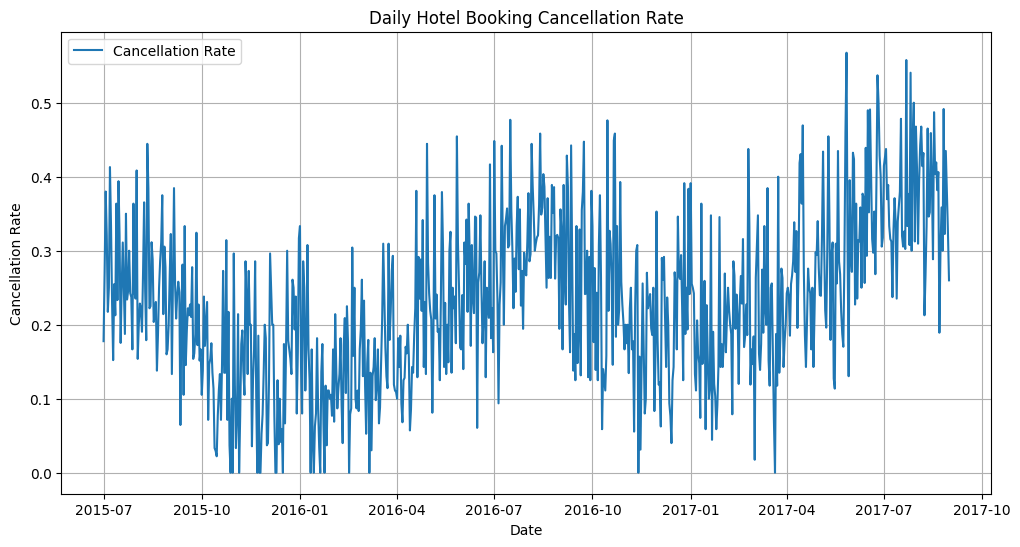

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data['cancellation_rate'], label='Cancellation Rate')
plt.title('Daily Hotel Booking Cancellation Rate')
plt.xlabel('Date')
plt.ylabel('Cancellation Rate')
plt.legend()
plt.grid()
plt.show()

In [ ]:
result = adfuller(daily_data.cancellation_rate[1:100].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: 0.07694080904467947
p-value: 0.9644510119603418
Critical Values: {'1%': np.float64(-3.5087828609430614), '5%': np.float64(-2.895783561573195), '10%': np.float64(-2.5850381719848565)}


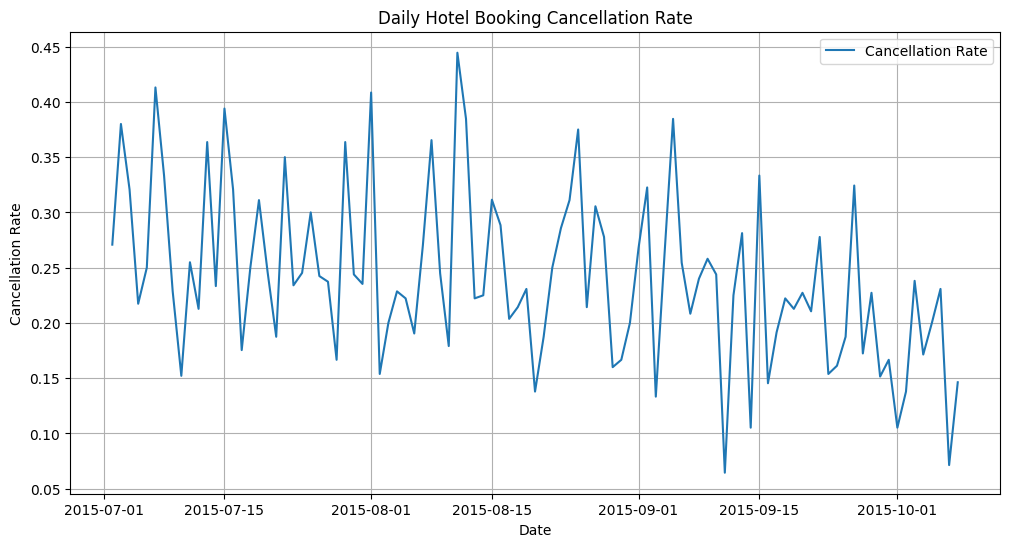

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index[1:100], daily_data.cancellation_rate[1:100], label='Cancellation Rate')
plt.title('Daily Hotel Booking Cancellation Rate')
plt.xlabel('Date')
plt.ylabel('Cancellation Rate')
plt.legend()
plt.grid()
plt.show()

In [ ]:
train_size = int(len(daily_data[1:80]))
train, test = daily_data.iloc[:train_size], daily_data.iloc[train_size-1:100]

In [ ]:
# Для моделей требуется колонка 'ds' (дата) и 'y' (целевая переменная)
df = daily_data.reset_index()[['arrival_full_date', 'cancellation_rate']]
df.columns = ['ds', 'y']

In [ ]:
train, test = df.iloc[:train_size], df.iloc[train_size-1:100]

In [ ]:
train

,total_bookings,cancellations,cancellation_rate
arrival_full_date,,,
2015-07-01,45,8,0.177778
2015-07-02,48,13,0.270833
2015-07-03,50,19,0.380000
2015-07-04,53,17,0.320755
2015-07-05,46,10,0.217391
...,...,...,...
2015-09-13,32,9,0.281250
2015-09-14,38,4,0.105263
2015-09-15,27,9,0.333333


In [ ]:
!pip install nixtla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.7 MB/s eta 0:00:00


In [ ]:
from nixtla import NixtlaClient

train_nx = train.rename(columns = {'cancellation_rate':'y'})

# Инициализация клиента (требуется API-ключ)
nixtla_client = NixtlaClient(api_key='nixak-luqLk9VRMv7ESNX0jxpfwGDrJovWYD1p5UG6SDcI0p96LGvqPPt4FxF6CqVAjmwiwfqdc6P1zi1xm8f7')

# Прогнозирование
forecast = nixtla_client.forecast(
    train_nx,
    h=22,  # Горизонт прогноза (14 дней)
    freq='D',  # Частота данных (дни)
    model='timegpt-1'
)
print(forecast.head())

          ds   TimeGPT
0 2015-09-18  0.208285
1 2015-09-19  0.221808
2 2015-09-20  0.226351
3 2015-09-21  0.228799
4 2015-09-22  0.238711


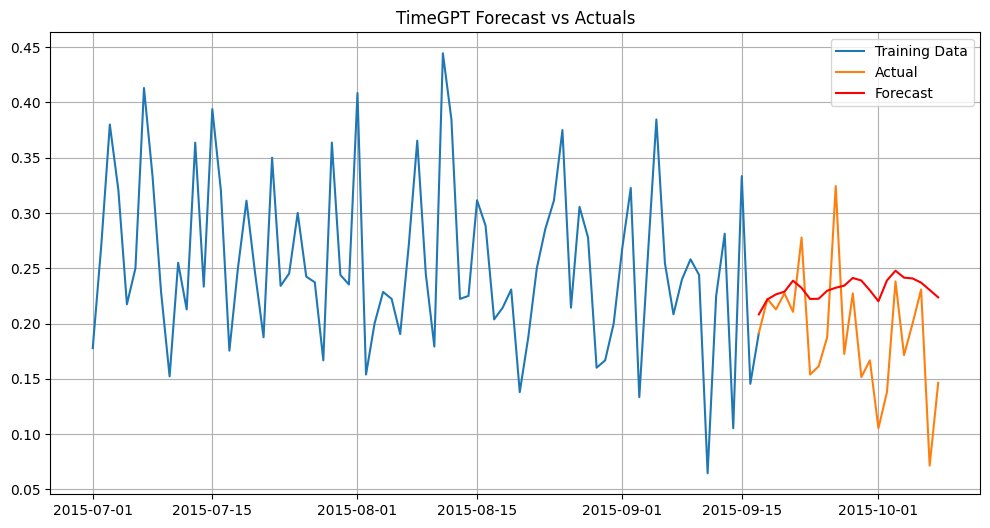

In [ ]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(train.index, train_nx['y'], label='Training Data')
plt.plot(test.index, test['cancellation_rate'], label='Actual')
plt.plot(test.index, forecast.TimeGPT, label='Forecast', color='red')
plt.title('TimeGPT Forecast vs Actuals')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Расчет метрик
mse = mean_squared_error(test['cancellation_rate'], forecast.TimeGPT)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['cancellation_rate'], forecast.TimeGPT)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

MSE: 0.0045
RMSE: 0.0671
MAE: 0.0534


### Сравнение с классическими методами

In [ ]:
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, 7)  # 7 дней в неделю

model = SARIMAX(train['cancellation_rate'],
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                 cancellation_rate   No. Observations:                   79
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                  67.146
Date:                           Mon, 05 May 2025   AIC                           -124.291
Time:                                   20:01:46   BIC                           -113.656
Sample:                               07-01-2015   HQIC                          -120.115
                                    - 09-17-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0194      0.148     -0.131      0.896      -0.310       0.271
ma.L1         -1.0001     80.503     -0.012

In [ ]:
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

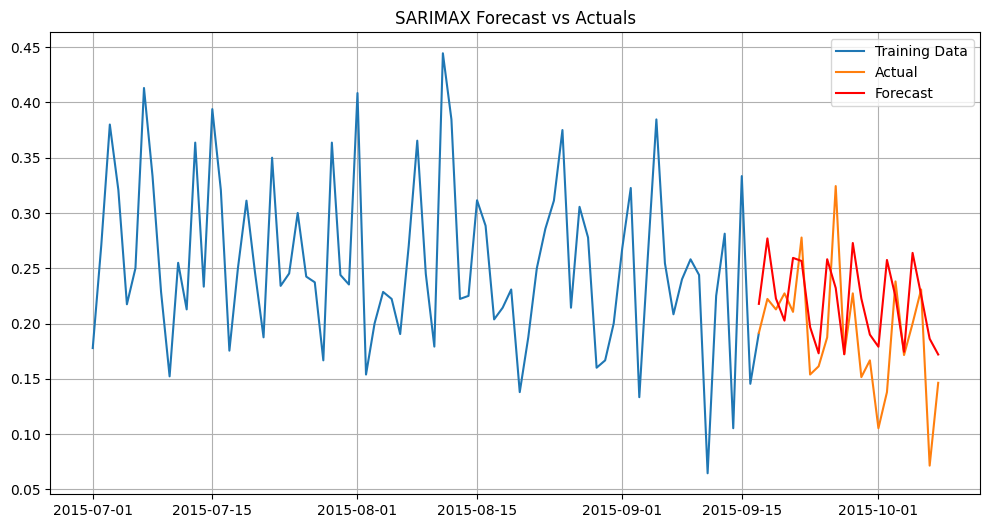

In [ ]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['cancellation_rate'], label='Training Data')
plt.plot(test.index, test['cancellation_rate'], label='Actual')
plt.plot(test.index, forecast_mean, label='Forecast', color='red')
plt.title('SARIMAX Forecast vs Actuals')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Расчет метрик
mse = mean_squared_error(test['cancellation_rate'], forecast_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['cancellation_rate'], forecast_mean)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

MSE: 0.0031
RMSE: 0.0557
MAE: 0.0438


In [ ]:
prophet_data = daily_data[['cancellation_rate']].reset_index()
prophet_data.columns = ['ds', 'y']  # переименовываем колонки
prophet_data.head()

,ds,y
0,2015-07-01,0.177778
1,2015-07-02,0.270833
2,2015-07-03,0.380000
3,2015-07-04,0.320755
4,2015-07-05,0.217391


In [ ]:
train_size = int(len(prophet_data[1:80]))
train, test = prophet_data.iloc[:train_size], prophet_data.iloc[train_size-1:100]

In [ ]:
from prophet import Prophet

# Создаём модель
model = Prophet(
    growth='linear',               # линейный тренд
    seasonality_mode='additive',   # аддитивная сезонность
    yearly_seasonality=True,       # учитываем годовую сезонность
    weekly_seasonality=True,       # учитываем недельную сезонность
    daily_seasonality=False        # если нет дневных данных
)

# Добавляем пользовательскую сезонность (например, месячную)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Обучаем модель на тренировочных данных
model.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp1txmlycq/w2ea7wa1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1txmlycq/e84qiu37.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26627', 'data', 'file=/tmp/tmp1txmlycq/w2ea7wa1.json', 'init=/tmp/tmp1txmlycq/e84qiu37.json', 'output', 'file=/tmp/tmp1txmlycq/prophet_modelww5olqt3/prophet_model-20250505202045.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:20:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Создаём DataFrame с датами для прогноза (включая тестовый период)
future = model.make_future_dataframe(periods=len(test), freq='D')

# Получаем прогноз
forecast = model.predict(future)

# Смотрим прогнозируемые значения
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
96,2015-10-05,1.010136,0.932701,1.092143
97,2015-10-06,0.996844,0.911293,1.076779
98,2015-10-07,0.892975,0.814065,0.975884
99,2015-10-08,0.678306,0.598670,0.760981
100,2015-10-09,0.477768,0.395656,0.560342


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Выбираем только те даты, которые есть в тестовой выборке
forecast_test = forecast.iloc[-len(test):]

# Считаем метрики
mae = mean_absolute_error(test['y'], forecast_test['yhat'])
rmse = mean_squared_error(test['y'], forecast_test['yhat'])

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.5844
RMSE: 0.4433


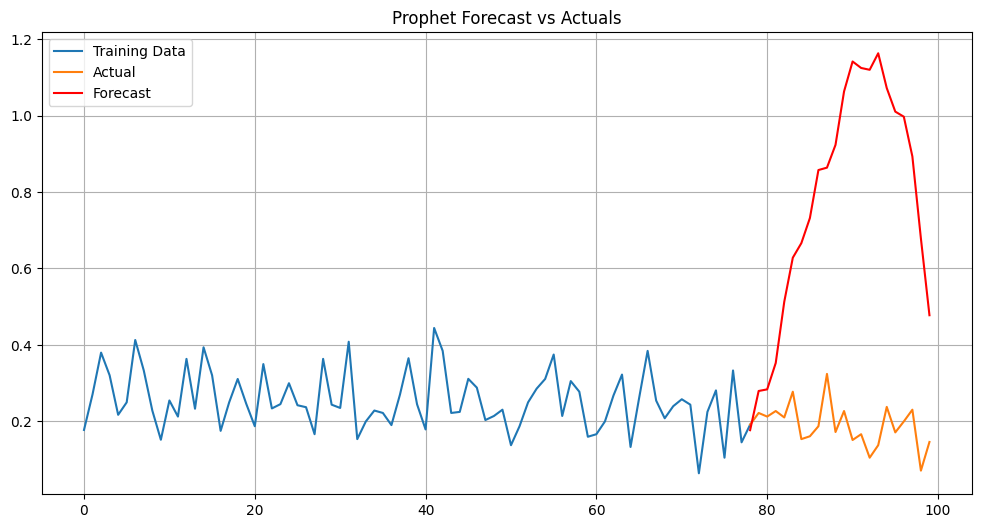

In [ ]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['y'], label='Training Data')
plt.plot(test.index, test['y'], label='Actual')
plt.plot(test.index, forecast.yhat[79:], label='Forecast', color='red')
plt.title('Prophet Forecast vs Actuals')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Расчет метрик
mse = mean_squared_error(test['y'], forecast.yhat[79:])
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['y'], forecast.yhat[79:])

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

MSE: 0.4433
RMSE: 0.6658
MAE: 0.5844


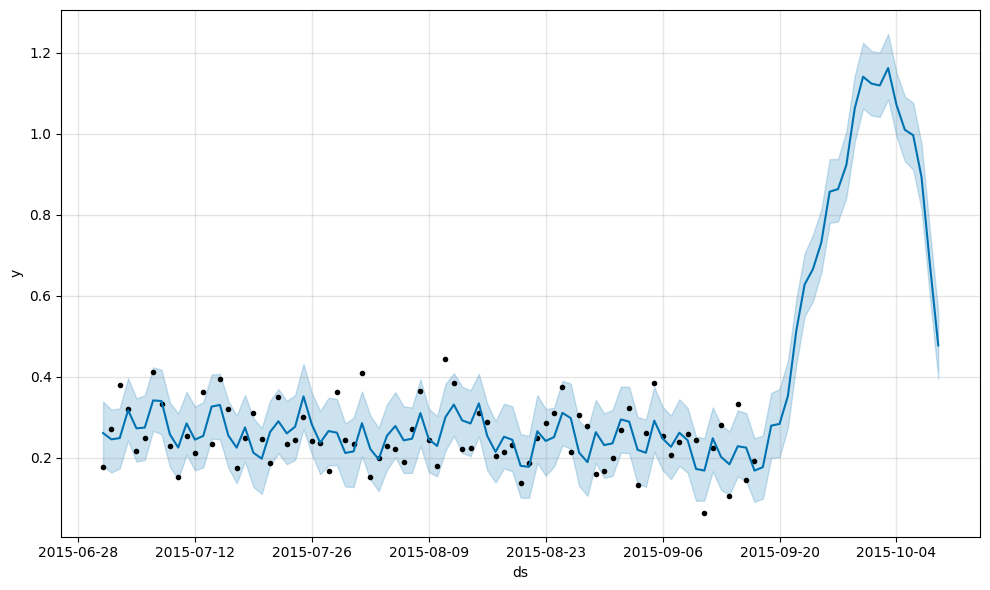

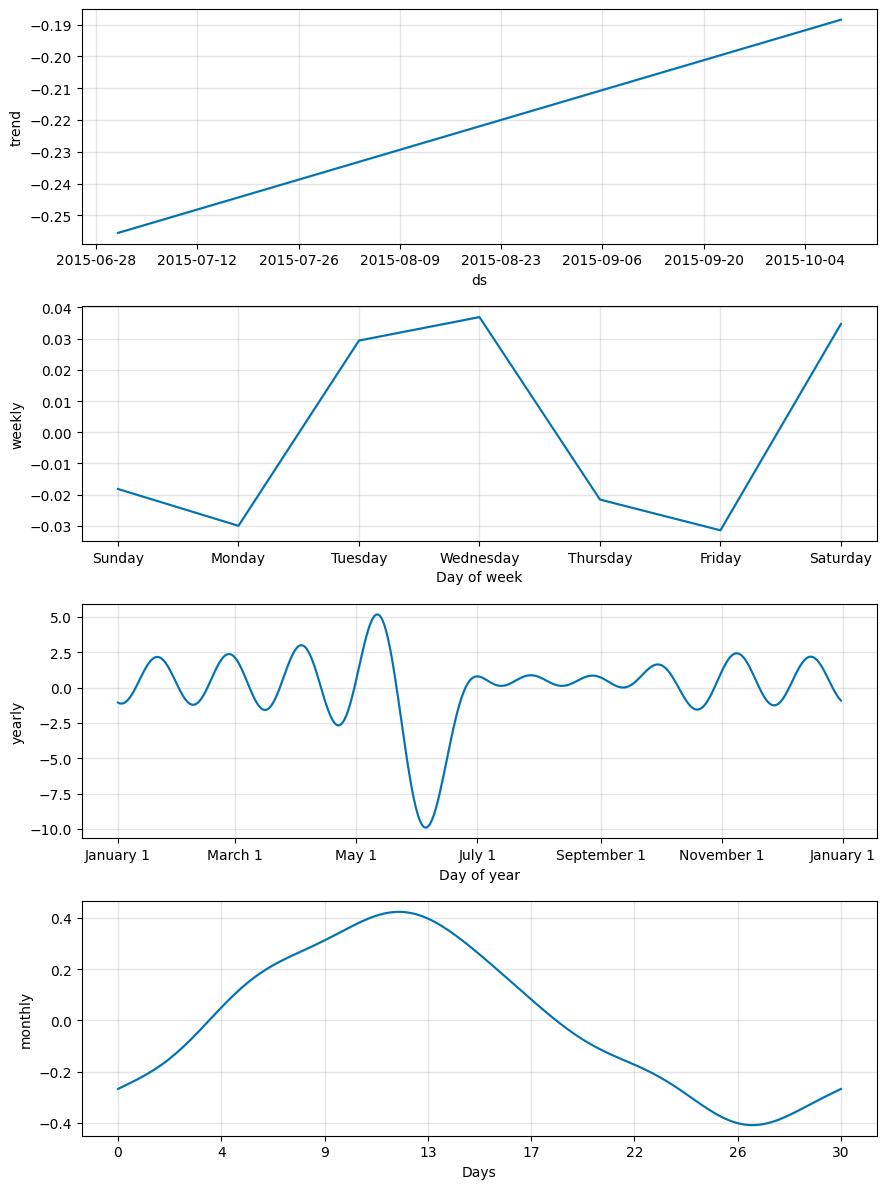

In [ ]:
from prophet.plot import plot_plotly

# График прогноза
fig1 = model.plot(forecast)

# Компоненты прогноза (тренд, сезонность)
fig2 = model.plot_components(forecast)